In [1]:
import datetime
import warnings

import numpy as np
import pandas as pd
import scipy as sp
from scipy.stats import entropy
from sklearn.neighbors import KernelDensity

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

warnings.filterwarnings(action='ignore')

In [2]:
noise_df = pd.read_excel('data/snp-noise-data.xlsx', index_col=0)
len(noise_df)

8313

In [3]:
noise_df[['Noise']].describe()

,Noise
count,8313.000000
mean,-0.532262
std,57.519585
min,-693.266907
25%,-18.671936
50%,-0.219101
75%,18.540009
max,386.008118


In [4]:
period_df = noise_df.copy(deep=True)
period_df['year'] = period_df.index.year
period_df['Period Category'] = pd.cut(period_df['year'], bins=range(period_df['year'].min(), 2026, 5), right=False)
period_df = period_df.drop(columns=['year'])

In [5]:
for period_category in period_df['Period Category'].unique():
    period_df[period_category] = period_df['Noise'][period_df['Period Category'] == period_category]

In [6]:
period_grouped = pd.merge(period_df[['Noise']].describe(), 
                          period_df[['Noise', 'Period Category']].groupby('Period Category')
                                                                 .describe()
                                                                 .T
                                                                 .loc['Noise'], 
                          how='left', 
                          left_index=True, 
                          right_index=True
                          )
period_grouped = period_grouped.rename(columns={'Noise': 'Total'})
period_grouped

,Total,"[1990, 1995)","[1995, 2000)","[2000, 2005)","[2005, 2010)","[2010, 2015)","[2015, 2020)","[2020, 2025)"
count,8313.000000,1227.000000,1263.000000,1256.000000,1259.000000,1258.000000,1258.000000,792.000000
mean,-0.532262,-0.185756,-4.826336,4.131913,2.958129,-3.492723,-2.565333,0.765104
std,57.519585,8.497978,28.190559,37.795560,40.058404,34.508173,57.250751,146.155312
min,-693.266907,-30.842934,-147.297394,-154.920029,-156.835052,-140.184631,-319.825256,-693.266907
25%,-18.671936,-4.903790,-13.680580,-18.923645,-17.880981,-25.584869,-32.872009,-77.378540
50%,-0.219101,0.118286,-3.907196,6.467133,2.830566,-1.421677,-0.458801,-5.640808
75%,18.540009,5.027435,9.299911,29.792191,19.431213,20.242287,30.217239,73.101761
max,386.008118,29.029701,94.829407,97.707947,154.526123,96.833221,167.834656,386.008118


In [7]:
sns.set_style(style='whitegrid')
period_df = period_df.rename(columns={'Noise': 'Total'})

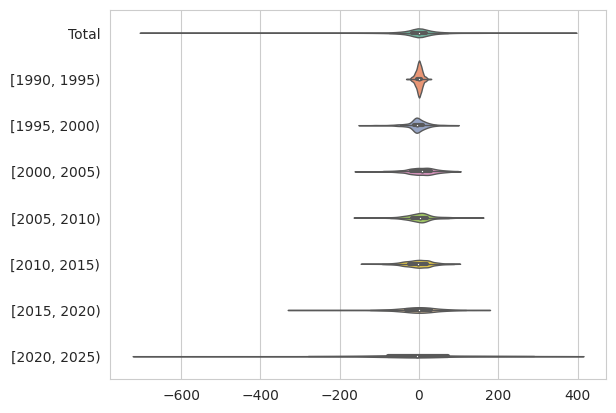

In [8]:
_ = sns.violinplot(period_df, orient='h', palette='Set2', bw=.2, cut=1, linewidth=1)

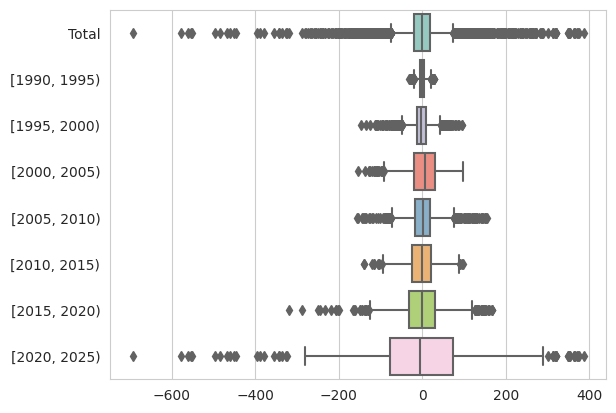

In [9]:
_ = sns.boxplot(data=period_df,
                palette='Set3',
                orient='h',
                )

In [12]:
# KL-Divergence
# Using KDE for Distribution Estimation

period_kde = dict()
distribution_df = period_df.drop(columns=['Period Category'])
period_kde['Total'] = KernelDensity(kernel='gaussian', bandwidth=10).fit(distribution_df['Total']
                                                                         .dropna()
                                                                         .values
                                                                         .reshape(-1, 1)
)
for period in distribution_df.columns[1:]:
    period_kde[period] = KernelDensity(kernel='gaussian', bandwidth=10).fit(distribution_df[period].dropna()
                                                                                                   .values
                                                                                                   .reshape(-1, 1)
    )
x = np.linspace(-50, 50, 10000).reshape(-1, 1)

kl_div_df = pd.DataFrame(columns=['Reference', 'Relative', 'KL-Divergence'])
total_period = distribution_df.columns[0]
total_density = np.exp(period_kde[total_period].score_samples(x)) # score_samples 는 log likelihood 를 반환함.
for prev_period, curr_period in zip(distribution_df.columns[1:], distribution_df.columns[2:]):
    prev_density = np.exp(period_kde[prev_period].score_samples(x))
    curr_density = np.exp(period_kde[curr_period].score_samples(x))
    kl_div = entropy(prev_density, curr_density)
    kl_div_df = kl_div_df.append({'Reference': prev_period,
                                  'Relative': curr_period,
                                  'KL-Divergence': kl_div},
                                  ignore_index=True)

kl_div_df.drop(columns=['Reference']).set_index('Relative').T

Relative,"[1995, 2000)","[2000, 2005)","[2005, 2010)","[2010, 2015)","[2015, 2020)","[2020, 2025)"
KL-Divergence,0.146408,0.112309,0.039716,0.013372,0.005766,0.014874


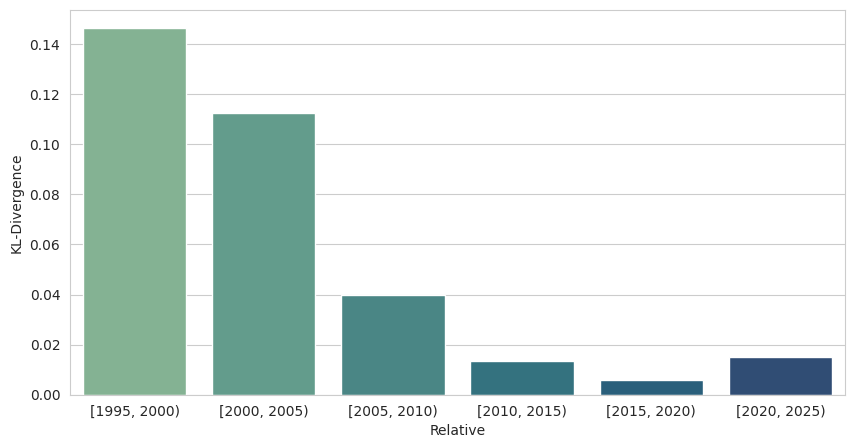

In [13]:
fig, ax = plt.subplots(figsize=(10, 5))
_ = sns.barplot(x='Relative', y='KL-Divergence', data=kl_div_df, palette='crest', ax=ax)

In [14]:
total_kl_div_df = pd.DataFrame(columns=['Period', 'KL-Divergence'])
for period in distribution_df.columns[1:]:
    period_density = np.exp(period_kde[period].score_samples(x))
    kl_div = entropy(total_density, period_density)
    total_kl_div_df = total_kl_div_df.append({'Period': period,
                                              'KL-Divergence': kl_div},
                                              ignore_index=True)

total_kl_div_df.set_index('Period').T

Period,"[1990, 1995)","[1995, 2000)","[2000, 2005)","[2005, 2010)","[2010, 2015)","[2015, 2020)","[2020, 2025)"
KL-Divergence,0.433735,0.023237,0.041333,0.004762,0.022615,0.0404,0.099992


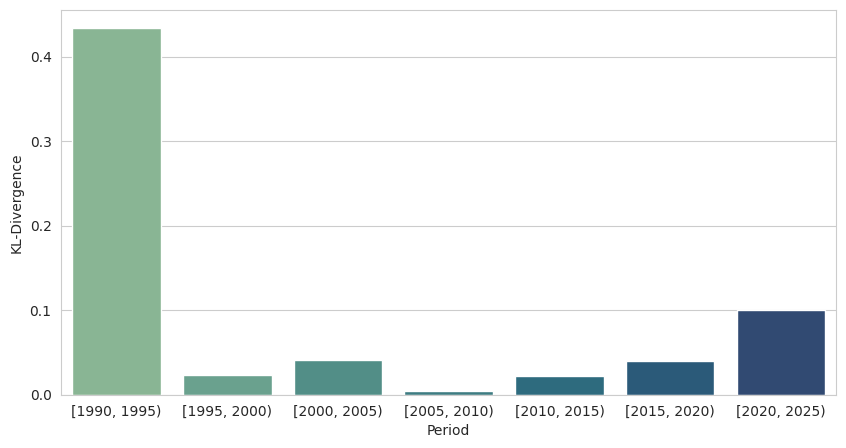

In [15]:
fig, ax = plt.subplots(figsize=(10, 5))
_ = sns.barplot(x='Period', y='KL-Divergence', data=total_kl_div_df, palette='crest', ax=ax)

In [16]:
# Quantitive Shifts
noise_df['After Robo-Advisor'] = noise_df.index >= pd.Timestamp('2007-01-01')
noise_df['After 3rd Quantitative Easing'] = noise_df.index >= pd.Timestamp('2012-09-01')

# Crisis
noise_df['Dot-com Bubble'] = ((pd.Timestamp('1996-03-01') <= noise_df.index)
                              & (noise_df.index <= pd.Timestamp('2001-01-01')))
noise_df['The Great Recession'] = ((pd.Timestamp('2008-09-01') <= noise_df.index)
                                   & (noise_df.index <= pd.Timestamp('2009-06-01')))
noise_df['European Debt Crisis'] = ((pd.Timestamp('2010-03-01') <= noise_df.index)
                                    & (noise_df.index <= pd.Timestamp('2012-01-01')))
noise_df['Brexit'] = ((pd.Timestamp('2016-02-01') <= noise_df.index)
                      & (noise_df.index <= pd.Timestamp('2019-01-01')))
noise_df['COVID-19 Pandemic'] = pd.Timestamp('2020-02-01') <= noise_df.index

In [17]:
quantitive_shift_columns = [
    'After Robo-Advisor', 
    'After 3rd Quantitative Easing',
    ]

crisis_columns = [
    'Dot-com Bubble', 
    'The Great Recession', 
    'European Debt Crisis',
    'Brexit',
    'COVID-19 Pandemic', 
    ]

In [18]:
def get_period(df, columns):
    new_df = pd.DataFrame()
    new_df['Total'] = df['Noise']
    new_df = pd.concat([new_df, 
                        pd.DataFrame({column: df['Noise'][noise_df[column]] for column in columns})
                        ], 
                       axis=1
                       )
    return new_df

In [19]:
quantitive_shift_period = get_period(noise_df, quantitive_shift_columns)
quantitive_shift_period.describe()

,Total,After Robo-Advisor,After 3rd Quantitative Easing
count,8313.000000,4064.000000,2635.000000
mean,-0.532262,-0.548283,-2.150792
std,57.519585,77.445345,90.506801
min,-693.266907,-693.266907,-693.266907
25%,-18.671936,-31.890381,-37.011993
50%,-0.219101,0.056076,-1.340881
75%,18.540009,28.246933,29.887024
max,386.008118,386.008118,386.008118


In [20]:
crisis_period = get_period(noise_df, crisis_columns)
crisis_period.describe()

,Total,Dot-com Bubble,The Great Recession,European Debt Crisis,Brexit,COVID-19 Pandemic
count,8313.000000,1221.000000,188.000000,466.000000,735.000000,771.000000
mean,-0.532262,-1.820364,-7.647145,-1.914049,-4.401704,-5.073210
std,57.519585,33.995119,66.459960,39.849681,55.332249,143.580721
min,-693.266907,-147.297394,-156.835052,-115.181824,-319.825256,-693.266907
25%,-18.671936,-18.284607,-48.141491,-27.097763,-30.941681,-80.854736
50%,-0.219101,-0.992416,-9.906319,-1.901031,-5.204834,-9.520874
75%,18.540009,17.357117,19.466770,21.794052,20.860229,57.478027
max,386.008118,97.696442,154.526123,96.833221,167.834656,386.008118


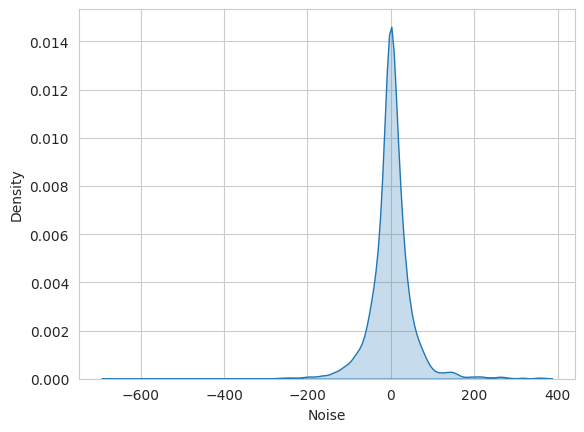

In [21]:
_ = sns.kdeplot(noise_df['Noise'], shade=True, cut=.1)

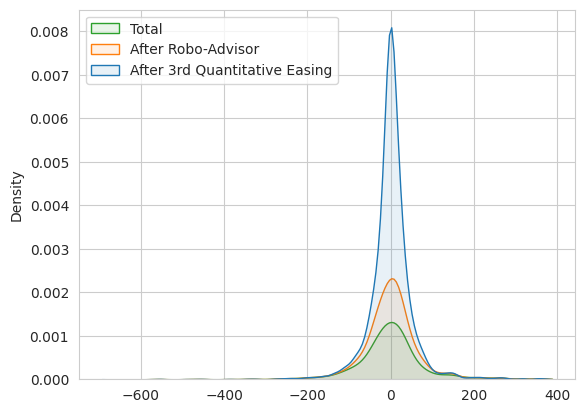

In [22]:
ax = sns.kdeplot(data=quantitive_shift_period, shade=True, cut=.1, alpha=.1)
_ = ax.legend(quantitive_shift_period.columns, loc='upper left')

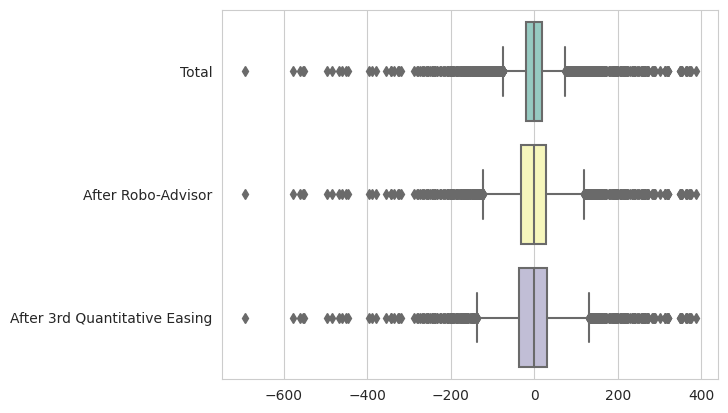

In [23]:
_ = sns.boxplot(data=quantitive_shift_period, 
                orient='h', 
                palette='Set3'
                )

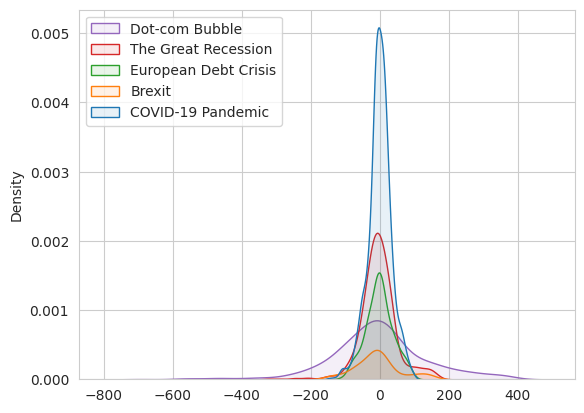

In [24]:
crisis_period = crisis_period.drop(columns=['Total'])
ax = sns.kdeplot(
    data=crisis_period,
    fill=True,
    alpha=.1,
)
_ = ax.legend(crisis_period.columns, loc='upper left')

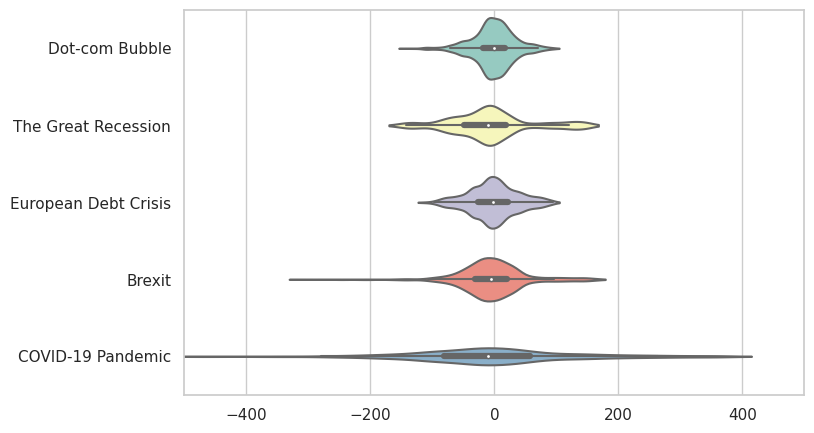

In [25]:
sns.set_theme(style='whitegrid')
fig, ax = plt.subplots(figsize=(8, 5))
sns.violinplot(data=crisis_period, 
               cut=1, 
               bw=.2,
               alpha=1,
               orient='h', 
               palette='Set3',
               ax=ax
               )
_ = ax.set(xlim=(-500, 500))

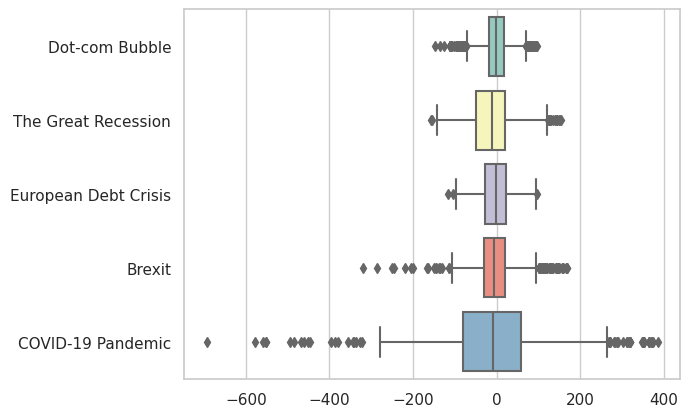

In [26]:
_ = sns.boxplot(data=crisis_period, 
                orient='h', 
                palette='Set3'
                )